In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve

In [50]:
df = pd.read_csv('/content/drive/MyDrive/슬기로운 건강생활/data(over_dis_vs_nor).csv', encoding='cp949')
df

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS,Dis
0,0,1,90,50,86,20.1,2,1
1,0,1,120,80,90,27.0,3,1
2,0,1,100,60,112,31.8,2,1
3,0,1,170,120,86,23.3,2,1
4,0,1,135,80,104,35.0,2,1
...,...,...,...,...,...,...,...,...
1481319,1,21,130,90,185,26.3,3,1
1481320,1,18,140,100,120,28.8,2,1
1481321,0,12,100,60,101,23.0,3,1
1481322,1,20,134,72,168,23.1,3,1


In [51]:
# 1번 모델 정답 지우기
train=df.drop(['Dis'], axis=1)

# 2번 모델 정답 중 '4' 모두 지우기
train = train.loc[train['DIS']!=4]
train.head()

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS
0,0,1,90,50,86,20.1,2
1,0,1,120,80,90,27.0,3
2,0,1,100,60,112,31.8,2
3,0,1,170,120,86,23.3,2
4,0,1,135,80,104,35.0,2


In [52]:
# target 설정
# train, test 나누기
yt = train['DIS']
xt = train.drop(['DIS'], axis=1)
xt = pd.DataFrame(xt)

# 데이터 정규화
# 표준 스케일러(평균 0, 분산 1)
scaler = MinMaxScaler()
xt = scaler.fit_transform(xt)

# train, test 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(xt, yt, test_size=0.5, random_state=42)

In [53]:
xt = pd.DataFrame(xt)

In [54]:
type(xt)

pandas.core.frame.DataFrame

In [56]:
feature_name = xt.columns

In [73]:
feature_name

RangeIndex(start=0, stop=6, step=1)

In [ ]:
# 설명변수명 리스트
feature_name = xt.columns
plt.figure(figsize=(30, 30))
for col_idx in range(len(feature_name)):
    # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
    plt.subplot(6, 2, col_idx+1)
    # 레드 와인에 해당하는 데이터 histogram 시각화
    plt.hist(df[df["target"] == 0][feature_name[col_idx]], label = "Red wine", alpha = 0.5)
    # 화이트 와인에 해당하는 데이터 histogram 시각화
    plt.hist(df[df["target"] == 1][feature_name[col_idx]], label = "White wine", alpha = 0.5)
    plt.legend()
    # 그래프 타이틀: feature name
    plt.title("Feature: "+ feature_name[col_idx], fontsize = 20)
plt.savefig('/content/drive/MyDrive/슬기로운 건강생활/relationship.png')
plt.show()

In [76]:
# 기본 모델 구성
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")

    y_pred = uncustomized.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred,average='micro'):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred,average='micro'):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred,average='micro'):.3f}") # F1 스코어
    print(classification_report(y_test, y_pred))


#    return train_score_before, test_score_before

        # 최종 모델의 성능 평가

    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(uncustomized, 
                         x_test, y_test,
                         include_values = True,
                         display_labels = ['1', '2','3'], # 목표변수 이름
                         values_format='d',
                         cmap = 'Pastel1') # 컬러맵
    plt.savefig('/content/drive/MyDrive/슬기로운 건강생활/' + algorithm_name + '_confusion_matrix(1).png') # 혼동행렬 자료 저장
    plt.show()

In [26]:
# 하이퍼 파라미터별 성능 시각화
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    plt.savefig('/content/drive/MyDrive/슬기로운 건강생활/' + algorithm_name + '_' + filename + '.png') # 시각화한 그래프는 로컬에 저장

# 모델 최적화 함수
## (1) 학습할 트리 모델 개수 선정

In [12]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))

## (2) 최대 깊이 선정

In [13]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

## (3) 분리 노드의 최소 자료 수 선정


In [14]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

## (4) 잎사귀 노드의 최소 자료 수 선정


In [15]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

# 최종 모델 학습

In [83]:
def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
    # 모델 저장
    model_path = '/content/drive/MyDrive/슬기로운 건강생활/'
    model_filename = 'wine_classification_' + algorithm_name + '.pkl'
    with open(model_path + model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"최종 모델 저장 완료! 파일 경로: {model_path + model_filename}\n")
    
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred,average='micro'):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred,average='micro'):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred,average='micro'):.3f}") # F1 스코어
    print(classification_report(y_test, y_pred))
    
    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                         x_test, y_test,
                         include_values = True,
                         display_labels = ['1', '2','3'], # 목표변수 이름
                         values_format='d',
                         cmap = 'Pastel1') # 컬러맵
    plt.savefig('/content/drive/MyDrive/슬기로운 건강생활/' + algorithm_name + '_confusion_matrix.png') # 혼동행렬 자료 저장
    plt.show()
    
    # 변수 중요도 산출
    dt_importance = pd.DataFrame()
    dt_importance['Feature'] = feature_name # 설명변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    # 변수 중요도 시각화
    coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    plt.savefig('/content/drive/MyDrive/슬기로운 건강생활/' + algorithm_name + '_feature_importance.png') # 변수 중요도 그래프 저장


    # #ROC 그래프
    
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # plt.plot([0, 1], [0, 1], "k--", label = '50% AUC')
    # plt.plot(fpr, tpr, label = "Random_classifier")
    # plt.xlabel("FPR")
    # plt.ylabel("TPR")
    # plt.title("ROC Curve - SGD_classifier")
    # plt.show()

# 기본 모델 학습

In [10]:
# 랜덤포레스트 분류 알고리즘
algorithm = RFC
algorithm_name = 'rfc'

In [11]:
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_train,
                                                          y_train,
                                                          x_test,
                                                          y_test)

학습 데이터셋 정확도: 0.999
테스트 데이터셋 정확도: 0.915


학습 데이터셋 정확도: 0.999
테스트 데이터셋 정확도: 0.915
Accuracy: 0.915
Precision: 0.915
Recall: 0.915
F1-score: 0.915
              precision    recall  f1-score   support

           1       0.90      0.92      0.91    123415
           2       0.92      0.87      0.90    123510
           3       0.93      0.95      0.94    123406

    accuracy                           0.92    370331
   macro avg       0.92      0.92      0.91    370331
weighted avg       0.92      0.92      0.91    370331



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 2160x2160 with 0 Axes>

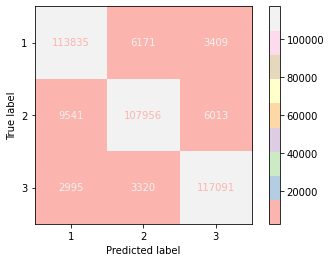

TypeError: ignored

In [77]:
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_train,
                                                          y_train,
                                                          x_test,
                                                          y_test)

# 최적화 모델 학습
## 그리드서치

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [30, 40, 50],  #100
          'max_depth' : [8, 9],   #8, 10, 12
          'min_samples_leaf' : [35],
          'min_samples_split' : [2]
          }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_jobs = -1) #random_state = 2022
#algorithm
grid_cv = GridSearchCV(rf_clf,
                       param_grid = params,
                       cv = 3, 
                       n_jobs = -1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 9, 'min_samples_leaf': 35, 'min_samples_split': 2, 'n_estimators': 50}
최고 예측 정확도: 0.5824


## (1) 트리 개수
- 트리 개수는 많을수록 과적합 방지에 유리

   n_estimators  TrainScore  TestScore
0             5      0.9882     0.8842
1            10      0.9951     0.8999
2            15      0.9970     0.9057
3            20      0.9977     0.9085
4            25      0.9981     0.9104
5            30      0.9983     0.9116
6            35      0.9984     0.9123
7            40      0.9984     0.9129
8            45      0.9985     0.9135


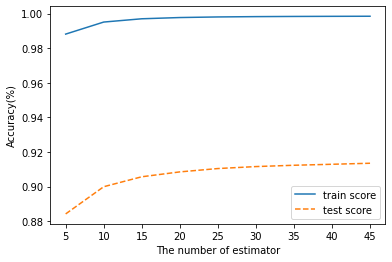

In [30]:
n_estimator_min = 1
n_estimator_max = 10
optimi_estimator(algorithm, algorithm_name, 
                 x_train, y_train, x_test, y_test, 
                 n_estimator_min, n_estimator_max)

In [32]:
n_estimator = 15

## (2) 최대 깊이
- 최대 깊이는 적을수록 과적합 방지에 유리

    depth  TrainScore  TestScore
0      10      0.5990     0.5897
1      11      0.6177     0.6018
2      12      0.6429     0.6187
3      13      0.6777     0.6427
4      14      0.7227     0.6747
5      15      0.7694     0.7091
6      16      0.8136     0.7433
7      17      0.8607     0.7812
8      18      0.8988     0.8122
9      19      0.9279     0.8386
10     20      0.9513     0.8603
11     21      0.9684     0.8772
12     22      0.9794     0.8873
13     23      0.9870     0.8947
14     24      0.9910     0.8991
15     25      0.9939     0.9022
16     26      0.9952     0.9043
17     27      0.9959     0.9046
18     28      0.9963     0.9055
19     29      0.9966     0.9062


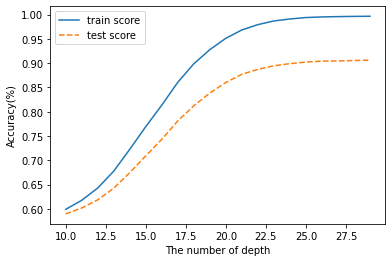

In [33]:
depth_min = 10
depth_max = 30
optimi_maxdepth(algorithm, algorithm_name, 
                x_train, y_train, x_test, y_test, 
                depth_min, depth_max, n_estimator)

In [34]:
n_depth = 25

## (3) 분리 노드의 최소 자료 수
- 분리 노드의 최소 자료 수는 많을수록 과적합 방지에 유리

   min_samples_split  TrainScore  TestScore
0                  2      0.9939     0.9022
1                  4      0.9858     0.8908
2                  6      0.9721     0.8740
3                  8      0.9578     0.8574
4                 10      0.9441     0.8437
5                 12      0.9311     0.8309
6                 14      0.9167     0.8172
7                 16      0.9030     0.8054
8                 18      0.8908     0.7953


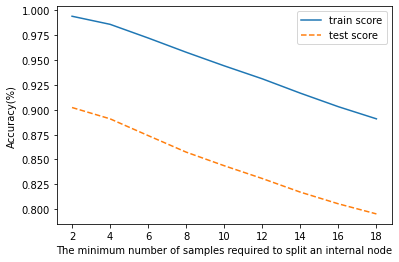

In [35]:
n_split_min = 1
n_split_max = 10
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 x_train, y_train, x_test, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

In [36]:
n_split = 2

## (4) 잎사귀 노드의 최소 자료 수
- 잎사귀 노드의 최소 자료 수는 많을수록 과적합 방지에 유리

   min_samples_leaf  TrainScore  TestScore
0                 2      0.9669     0.8661
1                 4      0.9160     0.8163
2                 6      0.8740     0.7800
3                 8      0.8374     0.7503
4                10      0.8074     0.7276
5                12      0.7811     0.7093
6                14      0.7603     0.6943
7                16      0.7416     0.6818
8                18      0.7269     0.6722


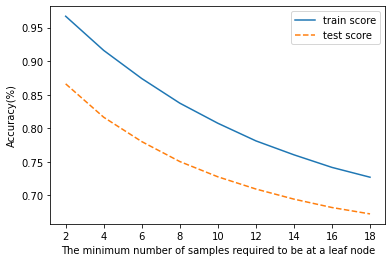

In [37]:
n_leaf_min = 1
n_leaf_max = 10
optimi_minleaf(algorithm, algorithm_name, 
               x_train, y_train, x_test, y_test, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

In [38]:
n_leaf = 2

# 최종모델 학습
- 다중 분류는 ROC 곡선 시각화 불가능

최종 모델 저장 완료! 파일 경로: /content/drive/MyDrive/슬기로운 건강생활/wine_classification_rfc.pkl

Accuracy: 0.866
Precision: 0.866
Recall: 0.866
F1-score: 0.866
              precision    recall  f1-score   support

           1       0.86      0.86      0.86    123415
           2       0.84      0.84      0.84    123510
           3       0.89      0.90      0.89    123406

    accuracy                           0.87    370331
   macro avg       0.87      0.87      0.87    370331
weighted avg       0.87      0.87      0.87    370331



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 2160x2160 with 0 Axes>

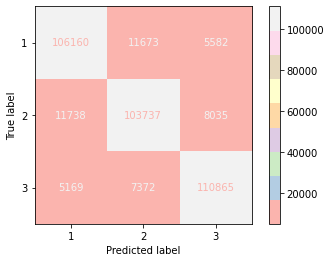

   Feature  Importance
4        4       0.329
5        5       0.228
2        2       0.152
3        3       0.135
1        1       0.129
0        0       0.027


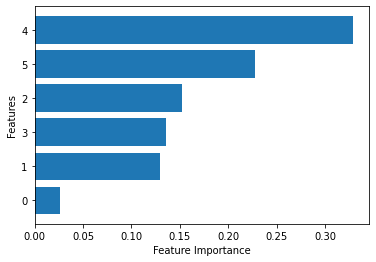

In [84]:
model_final(algorithm, algorithm_name, feature_name,
            x_train, y_train, x_test, y_test,
            n_estimator, n_depth, n_split, n_leaf)

# Reference
1. [시각화 부동소수점 변경](https://stackoverflow.com/questions/59990375/plot-confusioin-matrix-plot-is-not-showing-integer-value-instead-it-is-showing-s)
2. [ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].](https://magicode.tistory.com/38)